In [2]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
import os
os.environ.setdefault("HF_HOME", "/data/mjh24/hf")
os.environ.setdefault("TRANSFORMERS_CACHE", "/data/mjh24/hf/transformers")
os.makedirs(os.environ["TRANSFORMERS_CACHE"], exist_ok=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from Stage2.txtGraphPruning.display_txt_graph import draw_graph_from_arrays
from Stage2.txtGraphPruning.prune_txt_graph import main as prune_txt_graph
from Stage2.txtGraphPruning.graph_clustering import leiden_clustering, mini_graphs_from_clusters, louvain_clustering
from Stage2.classifyingEdges.classifyingFLANT5 import clean_instructional_text, classify_link_pairs_flan_batched
from Stage2.classifyingEdges.classifyingDeBerta import classify_node_isSentence, classify_node_isCatgory
from Stage2.classifyingEdges.rewritingOPENAI import add_context, summairse, summairse_clusters
from Stage2.classifyingEdges.classifyingOpenAI import classify_needsContext_openAI, classify_link_pairs_openAI, classify_pairwiseEdges_openAI
from Stage2.classifyingEdges.metrics import metrics
from itertools import combinations
from collections import defaultdict
from pathlib import Path
import numpy as np

CLIP_TO_N_EDGES_PER_NODE = 10 # This is to clip all the outgoing edges per node to a certain number
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
REMOVE_DUPES = False

### Step 1. ###
Load the model and download the website

In [3]:
# Load model
model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

# Load the website
htmlFile = "/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
#url = "https://westinghousenuclear.com/"
# url = "https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/"
# url = r"https://www.bbc.co.uk/news/live/cev28rvzlv1t"
# url = "https://www.nfl.com/teams/" # Great to show teams and structured data
# url = "https://www.energy.gov/ne/articles/advantages-and-challenges-nuclear-energy" #Great to show semi structured webpages with titles
# url = "https://westinghousenuclear.com/nuclear-fuel/fuel-fabrication-operations/"
# url = "https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/"
# htmlFile = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html")
# downloadHTML(url,1,htmlFile)

### Step 2. ###
Apply the graph model to extract all the possible edges.
This extracts all text nodes found and outputs all possible edges, along with their probabilities

In [4]:
# Get label edges from text nodes in the website
sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, alreadyConvertedToGraph="/vol/bitbucket/mjh24/IAEA-thesis/data/0000_test", remove_dupes=REMOVE_DUPES)
#sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, remove_dupes=REMOVE_DUPES)
model.to("cpu")         # offload to CPU
if torch.cuda.is_available():
    torch.cuda.empty_cache() # reclaim GPU cache

<Element tbody at 0x7dc301fb4540>
<Element td at 0x7dc301f701c0>


In [5]:
# Normalise the text
normtxt = []
for a, b in txts_extracted:
    normtxt.append([normalise_text(a, ".%'\\s", lower=False), normalise_text(b, ".%'\\s", lower=False)])
txts, probs, sorted_label_index, xpaths = np.array(normtxt), np.array(probs_extracted), np.array(sorted_label_index_extracted), np.array(xpaths_extracted)

Extract unique nodes from the edges and create a mapping from node to edge

In [6]:
node_unique_label_index, node_to_edge_pos = np.unique(sorted_label_index, return_index=True)
node_to_edge_pos = np.array([[int(idx/2),0] if idx%2==0 else [int(idx/2),1] for idx in node_to_edge_pos])
node_to_edge_x_pos, node_to_edge_y_pos = node_to_edge_pos[:,0], node_to_edge_pos[:,1]

node_unique_txts, node_unique_xpaths = txts[node_to_edge_x_pos,node_to_edge_y_pos], xpaths[node_to_edge_x_pos, node_to_edge_y_pos]

### Step 3. ###
This filters out all the nodes where the text is a button/navigational link.

This uses a FLAN-T5 model

In [7]:
# Remove all html instructional labels
txtsShortened = [[a.split(".")[0], b.split(".")[0]] for a, b in txts]
isButton, buttonTxt = clean_instructional_text(txtsShortened, batch_size=32)
opmask = np.array(isButton, dtype=bool)
mask = np.logical_not(opmask)

print("All the nodes filtered out:\n\n")
isButtonNode = np.zeros_like(node_unique_txts, dtype=bool)
for key, value in buttonTxt.items():
    if value == 1:
        idx = np.where(node_unique_txts==key)
        print(len(idx[0]),"-",key)
        isButtonNode[idx] = True

OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB. GPU 0 has a total capacity of 15.58 GiB of which 11.69 MiB is free. Process 3192183 has 7.30 GiB memory in use. Process 342324 has 4.33 GiB memory in use. Including non-PyTorch memory, this process has 3.84 GiB memory in use. Of the allocated memory 3.50 GiB is allocated by PyTorch, and 63.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
node_unique_label_index, node_to_edge_pos, node_unique_txts, node_unique_xpaths = node_unique_label_index[~isButtonNode], node_to_edge_pos[~isButtonNode], node_unique_txts[~isButtonNode], node_unique_xpaths[~isButtonNode]

### Step 4. ###
This filters out all the low probability edges using the finding from the probability paper. At least one edge per node is saved

In [ ]:
# -- RUN THE MAIN PRUNING MASK --
mask = prune_txt_graph(probs, sorted_label_index, toloerance=0.01, remove_dupes=REMOVE_DUPES)

# Concatanate and apply masks if we want specific text
mask = mask 
print(len(sorted_label_index), " -> ", len(sorted_label_index[mask]))
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
# -- PRUNING FINISHED --

11342  ->  522


### Step 5. ###
This filters out all the edges where the two text nodes make no sense together (i.e. they talk about different things)

In [ ]:
# Classify the edges
#classificationDeBerta, scoresDeberta = classify_link_pairs_zero_shot(txts, batch_size=64, confidence_Factor=0.9, return_scores=True)
#classificationDeBerta_twostep = classify_link_pairs_zero_shot_two_step(txts, batch_size=64, return_scores=False)
classificationFlan = classify_link_pairs_flan_batched(txts, batch_size=32)
#classificationOpenAI = classify_link_pairs_openAI(txts[:40])
#print(classificationDeBerta)
#print(classificationFlan)
#print(classificationDeBerta_twostep)
#print(classificationOpenAI)


In [ ]:
#Quick informal test
# y_true_str = "2 2 1 1 ? ? ? ? 3 3 1 1 3 3 2 2 2 2 1 1 ? ? 1 1 3 3 1 1 3 3 1 1 1 1 2 2 2 2 2 2"
# #classificationOpenAI = [1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1]
# y_true = [3 if tok == "?" else int(tok) for tok in y_true_str.split()]

In [ ]:
#metrics(classificationDeBerta[:len(y_true)], y_true)
#metrics(classificationFlan[:len(y_true)], y_true)
#metrics(classificationDeBerta_twostep[:len(y_true)], y_true)
#metrics(classificationOpenAI[:len(y_true)], y_true)

In [ ]:
# if len(classificationFlan) != len(txts):
#     raise Exception("The classification is not the same length as the number of edges")
# for (pair, lab) in zip(txts, classificationFlan):
#         print(lab, pair)

#for (pair, lab, sc) in zip(txts, classificationDeBerta, scoresDeberta or []):
#        print(lab, pair, "| scores:", {k: round(v, 3) for k, v in sc.items()})

In [ ]:
mask = np.array([(False if i==3 else True) for i in classificationFlan])
print("Removing the following edges:\n\n", txts[~mask])
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

Removing the following edges:

 [['addict' 'accident']
 ['drugs' 'accident']
 ['Panavision' 'Corrections to this Entry']
 ['lawyer' 'accident']
 ['accident' 'lawyer']
 ['lawyer' 'addict']
 ['addict' 'lawyer']
 ['British Columbia Canada' 'Corrections to this Entry']
 ['drugs' 'lawyer']
 ['addict' 'disaster']
 ['drugs' 'disaster']
 ['disaster' 'lawyer']
 ['lawyer' 'disaster']
 ['Year' '110 min.']
 ['110 min.' 'Year']
 ['drugs' 'child']
 ['child' 'lawyer']
 ['lawyer' 'child']
 ['MPAA Rating' 'Canada']
 ['addict' 'child']
 ['child' 'disaster']
 ['disaster' 'child']
 ['Ego Film Arts' 'Alliance Atlantis Communications']
 ['drugs' 'drowning']
 ['drowning' 'lawyer']
 ['lawyer' 'drowning']
 ['addict' 'drowning']
 ['Redemption' 'Death of a Child']
 ['Fine Line Features' 'Alliance Atlantis Communications']
 ['lawsuit' 'drowning']
 ['drowning' 'lawsuit']
 ['MPAA Rating' 'Countries']
 ['Countries' 'MPAA Rating']
 ['lawsuit' 'child']
 ['Enigmatic' 'Bleak']
 ['drugs' 'lawsuit']
 ['addict' 'lawsuit']


### 6. Finding each node that needs context to make a complete fact ###

    1) It uses DeBERTa-v3 model to split the nodes into more than a phrase and less that a phrase

For those that are <b> more than a phrase </b>

    2.1) GPT_4.1_mini decides if the sentences need more context

For those that are <b> less than a phrase </b>

    2.2) Use DeBERTa to categorise the value

The reason they are split is that it is a lot easier to create sentences from small "value to value" pairs. It is also good as the "value to sentence" edges are easier to extract information from if we know which are sentences (that need context) and which are values (that give context).

In [ ]:
isSentence, isSentence_probs = classify_node_isSentence(node_unique_txts.tolist(), batch_size=32)
for isS, txt in zip(isSentence, node_unique_txts):
    print(isS, txt)

0 Employment
0 Product Submissions
0 Advertising
0 Terms of Service
0 Copyright Policy
0 Coming Soon
0 In Theaters
0 Essays
0 Glossary
0 New Releases
0 Quick Browse
0 AllMovie Blog
0 In the Spotlight
0 Ennio de Concini 1923
0 Douglas Fairbanks Jr. 1909
0 Donald Byrd 1932
0 John Cassavetes 1929
0 Overview
0 Review
0 Cast
1 Production Credits
0 Awards
0 The Sweet Hereafter
0 Similar Works
1 L'Humanit 1999 Bruno Dumont
0 In the Bedroom 2001 Todd Field
1 The Son's Room 2001 Nanni Moretti
1 The Bed You Sleep In 1993 Jon Jost
0 The Pledge 2001 Sean Penn
1 Family Viewing 1987 Atom Egoyan
0 Blue 1993 Krzysztof Kieslowski
0 The Ice Storm 1997 Ang Lee
1 The Five Senses 1999 Jeremy Podeswa
0 Eureka 2000 Shinji Aoyama
0 Other Related Works
0 The War Zone 1999 Tim Roth
1 Plot Synopsis
0 by Jason Ankeny
1 Atom Egoyan's haunting adaptation of the Russell Banks novel The Sweet Hereafter was the Canadian filmmaker's most successful film to date taking home a Special Grand Jury Prize at the 1997 Cannes 

In [ ]:
isSentence = np.array(isSentence, dtype=bool)
node_sentences, node_sentences_xpaths = node_unique_txts[isSentence], node_unique_xpaths[isSentence]
if len(node_sentences) > 0:
    ####################################################################################################################Random to not waste money
    #sentenceNeedsContext = np.random.randint(2, size=node_sentences.shape)#
    sentenceNeedsContext, cost_needsContext, _ = classify_needsContext_openAI(node_sentences, dry_run_confirm=False, batch_size=1, return_raw_response_and_cost=True)
    ####################################################################################################################
    sentenceNeedsContext=np.array(sentenceNeedsContext, dtype=bool)
    #Re padding and getting back to the dimension of node_unique_txts
    padded_sentenceNeedsContext = np.zeros(isSentence.shape, dtype=bool)
    padded_sentenceNeedsContext[isSentence] = sentenceNeedsContext
    print("Sentences that need context: ", node_unique_txts[padded_sentenceNeedsContext])


Expected total price: $0.0005056

Batch 0 ~input tokens=103, ~output tokens=2, est. cost=$0.0005 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 99  {input_tokens= 97  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 4.2000000000000004e-05  This batch cost: $ 4.2000000000000004e-05
output so far:  [NEWBATCH]0
results so far:  [0]

Batch 1 ~input tokens=111, ~output tokens=2, est. cost=$0.0005 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 107  {input_tokens= 105  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 8.72e-05  This batch cost: $ 4.52e-05
output so far:  [NEWBATCH]0[NEWBATCH]0
results so far:  [0, 0]

Batch 2 ~input tokens=112, ~output tokens=2, est. cost=$0.0005 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 108  {input_tokens= 106  reasoning_tokens= 0  output_tokens= 2 }
Running Total cost: $ 0.0001328  This batch cost: $ 4.56e-05
output so far:  [NEWBATCH]0[NEWBATCH]0[NEWBATCH]0
results so far:  [0, 0, 0]

Batch 3 ~input tokens=112, ~output tokens=2, est. cost=$0.0005 

In [ ]:
node_words = node_unique_txts[~isSentence]
node_words_isCatgory, (_, bestCategory) = classify_node_isCatgory(node_words.tolist())
for idx, (isC, word) in enumerate(zip(node_words_isCatgory, node_words)):
    if not isC:
        bestCategory[idx] = ""
        print("XX ", word, " XX")
    else:
        print(word, "\t\t->", bestCategory[idx])

padded_node_words_isCatgory = np.zeros(isSentence.shape, dtype=int)
padded_bestCategory =  np.full(isSentence.shape, "", dtype=object)
padded_node_words_isCatgory[~isSentence] = node_words_isCatgory
padded_bestCategory[~isSentence] = bestCategory
for idx, (isC, word) in enumerate(zip(padded_node_words_isCatgory, node_unique_txts)):
    if not isC:
        padded_bestCategory[idx] = ""

XX  Employment  XX
XX  Product Submissions  XX
Advertising 		-> is only the name of a category
XX  Terms of Service  XX
Copyright Policy 		-> is briefly answering the question: Why?
Coming Soon 		-> is a comparison phrase
In Theaters 		-> is a comparison phrase
XX  Essays  XX
Glossary 		-> is only the name of a category
XX  New Releases  XX
XX  Quick Browse  XX
XX  AllMovie Blog  XX
XX  In the Spotlight  XX
Ennio de Concini 1923 		-> is only a date
Douglas Fairbanks Jr. 1909 		-> is only a date
Donald Byrd 1932 		-> is only a date
John Cassavetes 1929 		-> is only a date
XX  Overview  XX
Review 		-> is a comparison phrase
XX  Cast  XX
Awards 		-> is a comparison phrase
XX  The Sweet Hereafter  XX
Similar Works 		-> is a comparison phrase
In the Bedroom 2001 Todd Field 		-> is only a date
The Pledge 2001 Sean Penn 		-> is only a date
Blue 1993 Krzysztof Kieslowski 		-> is only a date
The Ice Storm 1997 Ang Lee 		-> is only a date
Eureka 2000 Shinji Aoyama 		-> is a number or amount
XX  

### 7a. Focus on Sentences that need Context ###
This decides which sentences to send off for context addition.

Current Sentence filters:
1) isButton
2) isSentence that needs context

<i>(note snall fact nodes will be dealt with through a different pipeline. They go through a different process)</i>

In [ ]:
padded_sentenceNeedsContext = np.array(padded_sentenceNeedsContext, dtype=bool)
node_label_NeedsContext = node_unique_label_index[padded_sentenceNeedsContext]
mask = np.isin(sorted_label_index[:,0], node_label_NeedsContext)
needsContext_text_edges, needsContext_xpaths = txts[mask], xpaths[mask]

print("Sentences being checked:")
for idx, isC in enumerate(padded_sentenceNeedsContext):
    if isC:
        print(node_unique_txts[idx])

Sentences being checked:
Haunted By the Past


In [ ]:
# Compute all pairwise-edges
# Creating an array of [SENTENCE, CTX1, CTX2] to compare them

outputs_by_input = {}
for inp, out in needsContext_text_edges:
    outputs_by_input.setdefault(inp, []).append(out)

needsContext_allPairwise_text = []
for inp, outs in outputs_by_input.items():
    if len(outs) < 2:
        continue  # need at least two outputs to form a pair

    pair_iter = combinations(outs, 2)
    for c1, c2 in pair_iter:
        needsContext_allPairwise_text.append([inp, c1, c2])
needsContext_allPairwise_text = np.array(needsContext_allPairwise_text)
print(len(needsContext_allPairwise_text))
print(needsContext_text_edges)

10
[['Haunted By the Past' 'Fathers and Daughters']
 ['Haunted By the Past' 'Death of a Child']
 ['Haunted By the Past' 'Redemption']
 ['Haunted By the Past' 'Infidelity']
 ['Haunted By the Past' 'Themes']]


In [ ]:
print(needsContext_text_edges)

[['Haunted By the Past' 'Fathers and Daughters']
 ['Haunted By the Past' 'Death of a Child']
 ['Haunted By the Past' 'Redemption']
 ['Haunted By the Past' 'Infidelity']
 ['Haunted By the Past' 'Themes']]


In [ ]:
BATCH_SIZE = 4
# expects: needsContext_allPairwise_text = [[INPUT, OUT1, OUT2], ...]

# Work on a mutable copy; keep as generic objects (strings/ints/etc.)
remaining = [list(t) for t in needsContext_allPairwise_text]
removedEdges = []

def _choose_smaller(inp, o1, o2):
    prob_1 = probs[((txts[:,0] == inp) & (txts[:,1] == o1))][0]
    prob_2 = probs[((txts[:,0] == inp) & (txts[:,1] == o2))][0]
    if prob_1 < prob_2: return o1
    if prob_2 < prob_1: return o2
    # tie
    return None  # "keep" => don't drop on ties

runningCost_pairwiseEdges = 0
while remaining:
    batch = remaining[:BATCH_SIZE]
    labels, cost, _ = list(classify_pairwiseEdges_openAI(batch, False, 4, True))
    runningCost_pairwiseEdges += cost
    print("Running cost: $", runningCost)
    if len(labels) != len(batch):
        raise ValueError("Classifier must return one label per triplet in the batch.")

    # Advance the window
    remaining = remaining[len(batch):]

    # For any label==0, note which outputs to drop for that INPUT
    drop_by_input = defaultdict(set)

    for triplet, y in zip(batch, labels):
        inp, o1, o2 = triplet
        print(o1)
        print(o2)
        print(y)
        print()
        if y == 0: # 0 means o1 and o2 are similar
            small = _choose_smaller(inp, o1, o2)
            if small:
                drop_by_input[inp].add(small)
                
                # Remove [inp, small] from the array edges we are considering
                mask = ~((needsContext_text_edges[:,0] == inp) & (needsContext_text_edges[:,1] == small))
                removedEdges.extend(needsContext_text_edges[~mask])
                needsContext_text_edges, needsContext_xpaths = needsContext_text_edges[mask], needsContext_xpaths[mask]

    # Filter out future triplets containing the marked outputs for the same INPUT
    if drop_by_input:
        new_remaining = []
        for t in remaining:
            inp, o1, o2 = t
            drop_set = drop_by_input.get(inp)
            if drop_set and (o1 in drop_set or o2 in drop_set):
                continue  # remove this triplet from consideration
            new_remaining.append(t)
        remaining = new_remaining

print("Removed ", removedEdges)


Batch 0 ~input tokens=166, ~output tokens=8, est. cost=$0.0001 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 167  {input_tokens= 159  reasoning_tokens= 0  output_tokens= 8 }
Running Total cost: $ 7.64e-05  This batch cost: $ 7.64e-05
output so far:  [NEWBATCH]1 1 1 1
results so far:  [1, 1, 1, 1]
Running cost: $ 7.64e-05
Fathers and Daughters
Death of a Child
1

Fathers and Daughters
Redemption
1

Fathers and Daughters
Infidelity
1

Fathers and Daughters
Themes
1


Batch 0 ~input tokens=161, ~output tokens=8, est. cost=$0.0001 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens= 162  {input_tokens= 154  reasoning_tokens= 0  output_tokens= 8 }
Running Total cost: $ 7.44e-05  This batch cost: $ 7.44e-05
output so far:  [NEWBATCH]1 1 1 0
results so far:  [1, 1, 1, 0]
Running cost: $ 0.0001508
Death of a Child
Redemption
1

Death of a Child
Infidelity
1

Death of a Child
Themes
1

Redemption
Infidelity
0


Batch 0 ~input tokens=108, ~output tokens=8, est. cost=$0.0000 (IN=$0.4/1M, OUT=$1.6/1M)
Total_tokens=

In [ ]:
print(len(needsContext_text_edges), len(node_sentences[~sentenceNeedsContext]))
facts_context, cost_add_context = add_context(needsContext_text_edges, dry_run_confirm=False, return_raw_response_and_cost=True)
facts_noContext, cost_summarise = summairse(node_sentences[~sentenceNeedsContext], dry_run_confirm=False, return_raw_response_and_cost=True)

print(facts_context)
print(facts_noContext)
print("Cost: $",cost_add_context+cost_summarise)

4 10
Expected total price: $0.0001462

Batch 1 (pairs 0..0): ~input tokens=111, ~output tokens=64, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
Total_tokens= 128  {input_tokens= 124  reasoning_tokens= 0  output_tokens= 4 }
Running Total cost: $ 1.4000000000000001e-05  This batch cost: $ 1.4000000000000001e-05
results so far:  ['NO FACTS']

Batch 2 (pairs 1..1): ~input tokens=111, ~output tokens=64, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
Total_tokens= 128  {input_tokens= 124  reasoning_tokens= 0  output_tokens= 4 }
Running Total cost: $ 2.8000000000000003e-05  This batch cost: $ 1.4000000000000001e-05
results so far:  ['NO FACTS', 'NO FACTS']

Batch 3 (pairs 2..2): ~input tokens=108, ~output tokens=64, est. cost=$0.0000 total cost=$0.0000 (IN=$0.1/1M, OUT=$0.4/1M)
Total_tokens= 125  {input_tokens= 121  reasoning_tokens= 0  output_tokens= 4 }
Running Total cost: $ 4.1700000000000004e-05  This batch cost: $ 1.3700000000000001e-05
results so far:  

In [ ]:
LISTOFFACTS = []
LISTOFXPATHS = []
for fact, xp in zip(facts_context, needsContext_xpaths):
    if "NO FACTS" not in fact:
        LISTOFFACTS.append(fact)
        LISTOFXPATHS.append(xp)

for fact, xp in zip(facts_noContext, node_sentences_xpaths):
    if "NO FACTS" not in fact:
        LISTOFFACTS.append(fact)
        LISTOFXPATHS.append([xp])

for f, xp in zip(LISTOFFACTS, LISTOFXPATHS):
    print(f)
    print(xp)
    print()

L'Humanité is a publication from the year 1999.  
Bruno Dumont is associated with L
[np.str_('/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[2]/tbody/tr[2]/td[2]')]

The Son's Room is a film released in 2001.  
Nanni Moretti is associated with The Son's Room.
[np.str_('/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[2]/tbody/tr[4]/td[2]')]

The Bed You Sleep In is a film released in 1993.  
Jon Jost is associated with The Bed You Sleep In
[np.str_('/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[2]/tbody/tr[5]/td[2]')]

Family Viewing is a film released in 1987.  
Atom Egoyan is associated with the film Family Viewing.
[np.str_('/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[2]/tbody/tr[7]/td[2]')]

The Five Senses is a film released in 1999.  
Jeremy Podeswa is associated with The Five Senses.
[np.

In [ ]:
for idx, fact in enumerate(facts_context):
    print(needsContext_text_edges[idx])
    print("\t", fact)
print()
for idx, fact in enumerate(facts_noContext):
    print("\t",node_sentences[~sentenceNeedsContext][idx])
    print(fact)

['Haunted By the Past' 'Fathers and Daughters']
	 NO FACTS
['Haunted By the Past' 'Death of a Child']
	 NO FACTS
['Haunted By the Past' 'Redemption']
	 NO FACTS
['Haunted By the Past' 'Themes']
	 NO FACTS

	 Production Credits
NO FACTS
	 L'Humanit 1999 Bruno Dumont
L'Humanité is a publication from the year 1999.  
Bruno Dumont is associated with L
	 The Son's Room 2001 Nanni Moretti
The Son's Room is a film released in 2001.  
Nanni Moretti is associated with The Son's Room.
	 The Bed You Sleep In 1993 Jon Jost
The Bed You Sleep In is a film released in 1993.  
Jon Jost is associated with The Bed You Sleep In
	 Family Viewing 1987 Atom Egoyan
Family Viewing is a film released in 1987.  
Atom Egoyan is associated with the film Family Viewing.
	 The Five Senses 1999 Jeremy Podeswa
The Five Senses is a film released in 1999.  
Jeremy Podeswa is associated with The Five Senses.
	 Plot Synopsis
NO FACTS
	 Atom Egoyan's haunting adaptation of the Russell Banks novel The Sweet Hereafter was t

### 7b. Cluster the non sentence nodes together ###
This uses Leiden clustering. Louvain also available

This makes a new, simple classification of sentence as "more than x words" (instead of that above using FLAN-T5)

In [ ]:
#To still do: Link all the small text nodes
#Output XPaths so we know where the nodes came from
NUMWORDSPERSENTENCE = 7
manyWordsMask = np.zeros(len(sorted_label_index), dtype=bool)
for idx, (first, second) in enumerate(txts):
    if len(first.split()) > NUMWORDSPERSENTENCE or len(second.split()) > NUMWORDSPERSENTENCE:
        manyWordsMask[idx] = True

no_sent_label_index, no_sent_txts, no_sent_probs, no_sent_xpaths = sorted_label_index[~manyWordsMask], txts[~manyWordsMask], probs[~manyWordsMask], xpaths[~manyWordsMask]

node_meta = defaultdict(lambda: {"texts": set(), "xpaths": set()})
for (u, v), (t1, t2), (x1, x2) in zip(no_sent_label_index, no_sent_txts, no_sent_xpaths):
    node_meta[u]["texts"].add(t1); node_meta[u]["xpaths"].add(x1)
    node_meta[v]["texts"].add(t2); node_meta[v]["xpaths"].add(x2)

clusters = leiden_clustering(no_sent_label_index, no_sent_probs)
clusters = [cluster[::-1] for cluster in clusters] #Reorder as the output above seems to put titles at the bottom

FitnessResult(min=None, max=None, score=0.8769884757424086, std=None)


In [ ]:
for i, cluster in enumerate(clusters):
    print(f"  Cluster {i} -> nodes: {cluster}")
    for n in cluster:
        t = ", ".join(node_meta[n]["texts"])
        #print(f"    - Node {n}: text=[{t}]")
        print("\"",t,"\"", sep="", end=",\n")

  Cluster 0 -> nodes: [583, 431, 584, 434, 581, 425, 582, 428, 585, 586, 587, 443, 440, 437, 509]
"British Columbia Canada",
"Set In",
"for sexuality and some language",
"MPAA Reasons",
"In a Minor Key",
"Moods",
"Panavision",
"Cinematic Process",
"Alliance Atlantis Communications",
"Ego Film Arts",
"Fine Line Features",
"Corrections to this Entry",
"AMG Work ID",
"Produced by",
"V 155010",
  Cluster 1 -> nodes: [79, 83, 85, 81, 41, 45, 36, 35, 44, 39, 42, 38]
"Ennio de Concini 1923",
"Donald Byrd 1932",
"John Cassavetes 1929",
"Douglas Fairbanks Jr. 1909",
"New Releases",
"In the Spotlight",
"In Theaters",
"Coming Soon",
"AllMovie Blog",
"Glossary",
"Quick Browse",
"Essays",
  Cluster 2 -> nodes: [302, 301, 257, 259, 261, 263, 267, 269, 271, 273, 277, 275]
"by Jason Ankeny",
"Plot Synopsis",
"Similar Works",
"L'Humanit 1999 Bruno Dumont",
"In the Bedroom 2001 Todd Field",
"The Son's Room 2001 Nanni Moretti",
"The Pledge 2001 Sean Penn",
"Family Viewing 1987 Atom Egoyan",
"Blue 1993 Kr

Tried extra clustering within clusters but it didn't add much. Would of had to be fine tuned per website to give any useful information. semantic grouping would have been much better

In [ ]:
mini_graphs, mini_probs = mini_graphs_from_clusters(no_sent_label_index, no_sent_probs, clusters)
# mini_clusters = []
# for g, p in zip(mini_graphs, mini_probs):
#     print(g)
#     mini_cluster = louvain_clustering(g, p, 1.2)
#     print(mini_cluster)
#     print()
#     mini_clusters.append(mini_cluster)

In [ ]:
# for clusters in mini_clusters:
#     for i, cluster in enumerate(clusters):
#         print(f"  Cluster {i} -> nodes: {cluster}")
#         for n in cluster:
#             t = ", ".join(node_meta[n]["texts"])
#             #print(f"    - Node {n}: text=[{t}]")
#             print("\"",t,"\"", sep="", end=",\n")

Tried rudimentury grouping within clusters using an llm, but it didn't work too well enough to justify the cost

In [ ]:
# clusters_text = [[". ".join(node_meta[n]["texts"]) for n in cluster] for cluster in clusters]
# clusters_xpaths = [[". ".join(node_meta[n]["xpaths"]) for n in cluster] for cluster in clusters]
# print(clusters_text)

In [ ]:
# cluster_summaries, cost = summairse_clusters(clusters_text, dry_run_confirm=False, return_raw_response_and_cost=True)
# print("Cost: $",cost)
# print(cluster_summaries)

In [ ]:
# for model_outputs in cluster_summaries:
#     model_cluster = model_outputs.split("\n")
#     for m in model_cluster:
#         entries = m.strip().split(" | ")
#         print(entries)

### 8. Final fact output ###
Outputing all the facts and groupings found, with xpaths to lead back to the source

In [ ]:
# total cost
cost_add_context + cost_summarise + runningCost_pairwiseEdges + cost_needsContext

In [ ]:
new_edges = np.array(mini_graphs).flatten()

In [ ]:
for i, cluster in enumerate(clusters):
    textInCluster, xpathInCluster = [], []
    for n in cluster:
        t, xp = ", ".join(node_meta[n]["texts"]), ", ".join(node_meta[n]["xpaths"])
        textInCluster.append(t)
        xpathInCluster.append(xp)
    LISTOFFACTS.append(textInCluster)
    LISTOFXPATHS.append(xpathInCluster)
        

  Cluster 0 -> nodes: [509, 437, 440, 443, 587, 586, 585, 428, 582, 425, 581, 434, 584, 431, 583]
  Cluster 1 -> nodes: [38, 42, 39, 44, 35, 36, 45, 41, 81, 85, 83, 79]
  Cluster 2 -> nodes: [416, 569, 568, 567, 566, 565, 564, 563, 562, 561, 560, 559]
  Cluster 3 -> nodes: [275, 277, 273, 271, 269, 267, 263, 261, 259, 257, 301, 302]
  Cluster 4 -> nodes: [149, 388, 396, 394, 407, 551, 406, 404, 398, 550]
  Cluster 5 -> nodes: [422, 580, 579, 578, 577, 575, 576]
  Cluster 6 -> nodes: [419, 574, 573, 572, 571, 570]
  Cluster 7 -> nodes: [413, 558, 557, 556, 555]
  Cluster 8 -> nodes: [120, 116, 118, 112, 114]
  Cluster 9 -> nodes: [19, 15, 16, 18, 14]
  Cluster 10 -> nodes: [387, 385, 386, 383]
  Cluster 11 -> nodes: [410, 554, 553, 552]
  Cluster 12 -> nodes: [402, 403, 401]
  Cluster 13 -> nodes: [391, 549, 548]
  Cluster 14 -> nodes: [280, 278]


In [39]:
for f, xp in zip(LISTOFFACTS, LISTOFXPATHS):
    print(f)
    print(xp)
    print()

L'Humanité is a publication from the year 1999.  
Bruno Dumont is associated with L
[np.str_('/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[2]/tbody/tr[2]/td[2]')]

The Son's Room is a film released in 2001.  
Nanni Moretti is associated with The Son's Room.
[np.str_('/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[2]/tbody/tr[4]/td[2]')]

The Bed You Sleep In is a film released in 1993.  
Jon Jost is associated with The Bed You Sleep In
[np.str_('/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[2]/tbody/tr[5]/td[2]')]

Family Viewing is a film released in 1987.  
Atom Egoyan is associated with the film Family Viewing.
[np.str_('/html/body/div/div[3]/table/tbody/tr/td[1]/table/tbody/tr[2]/td/table/tbody/tr/td[2]/div/table[2]/tbody/tr[7]/td[2]')]

The Five Senses is a film released in 1999.  
Jeremy Podeswa is associated with The Five Senses.
[np.

### Final edge output ###
Here are the results after all the filtering


['AMG Work ID' 'V 155010']
['V 155010' 'AMG Work ID']


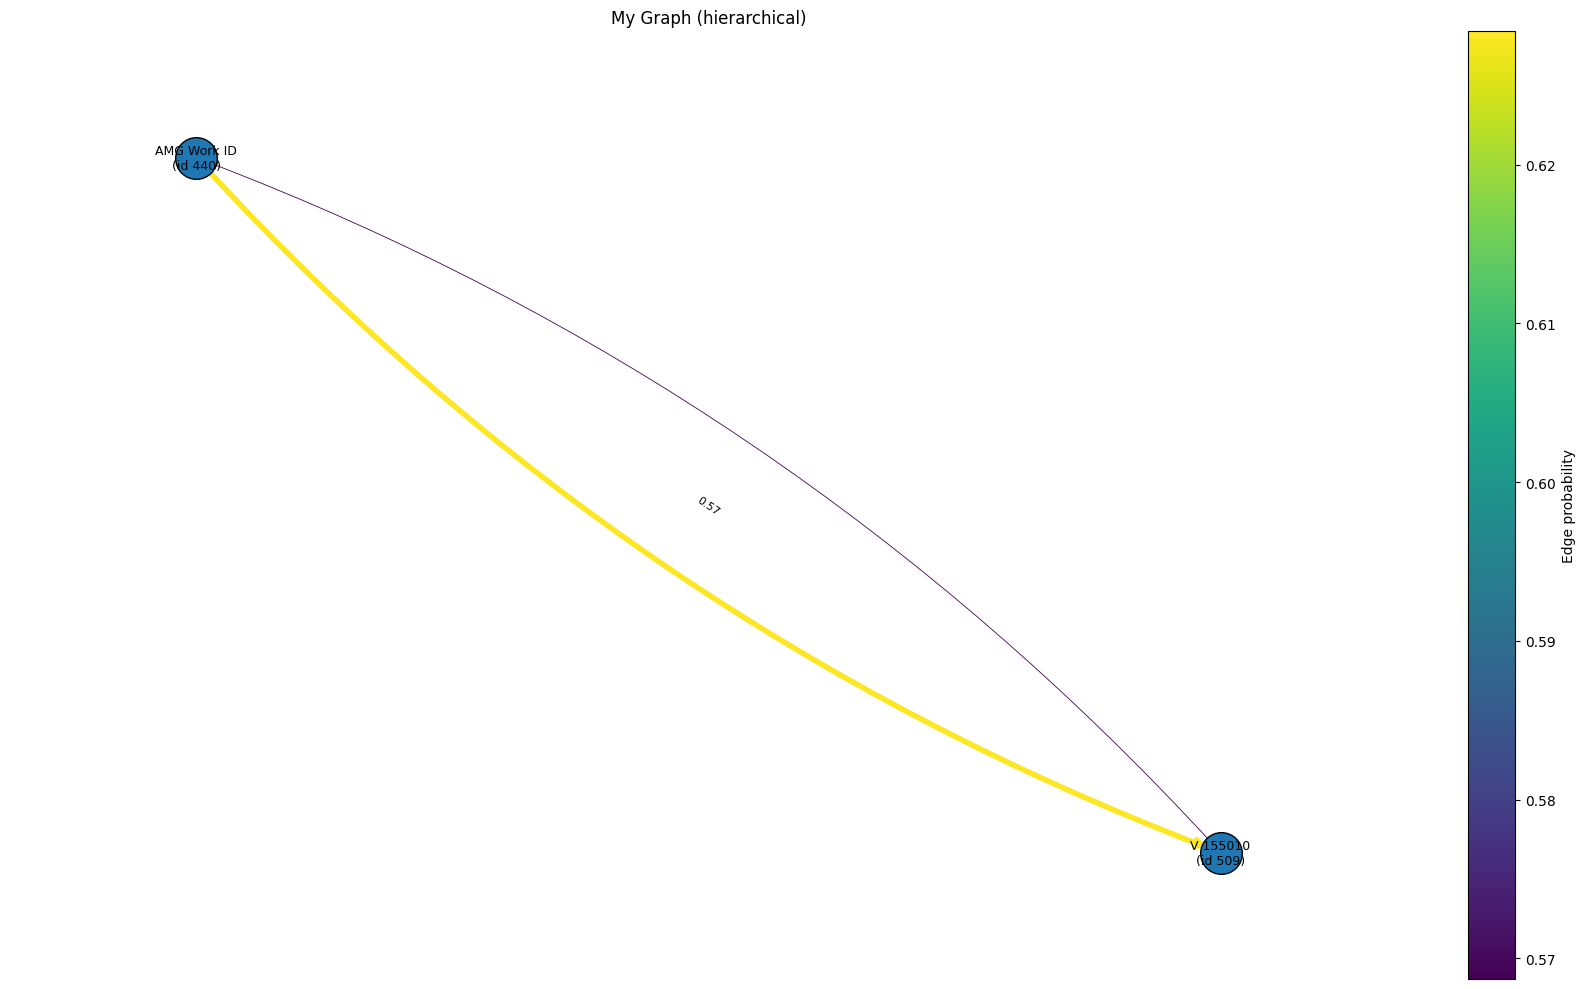

{'G': <networkx.classes.digraph.DiGraph at 0x7de75578f440>,
 'pos': {440: array([-1.        ,  0.98489875]),
  509: array([ 1.        , -0.98489875])},
 'fig': <Figure size 1600x1000 with 2 Axes>,
 'ax': <Axes: title={'center': 'My Graph (hierarchical)'}>}

In [ ]:
# Display the graph
#textmask = np.array([True]*len(txts))
textmask = filterTextMask(txts, "V 155010", False) #& mask = keepTopKMask(txts, 1)

numToShow=-1
for row in zip(no[textmask][:numToShow], xpaths[textmask][:numToShow], txts[textmask][:numToShow], probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=txts[textmask][:numToShow],
    id_edge_pairs=sorted_label_index[textmask][:numToShow],
    xpath_edge_pairs=xpaths[textmask][:numToShow],
    probs=probs[textmask][:numToShow],
    layout="spring",
    rankdir="TB",         # or "TB" for top→bottom
    layer_spacing=5.0,    # spread layers further
    node_spacing=2.5,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)